## Mean Metric figures

This notebook contains the code to generate figures associated with the mean metrics.

Results are stored in `../output/metric_figures/`

Start by importing necessary libraries and turning off warnings

In [1]:
import os, sys, importlib, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom as nbinom

sys.path.append( os.path.abspath(os.path.join('..')) )
import utils.forecast as forecast
import utils.utils as gen_utils

import warnings
warnings.filterwarnings('ignore')

# Opening config file
f = open('../fpaths_config.json')
paths = json.load(f)

metric_fil = paths["mean_metric_fil"]
metric_figures_path = paths['metric_figures_path']


## Justify scaling window

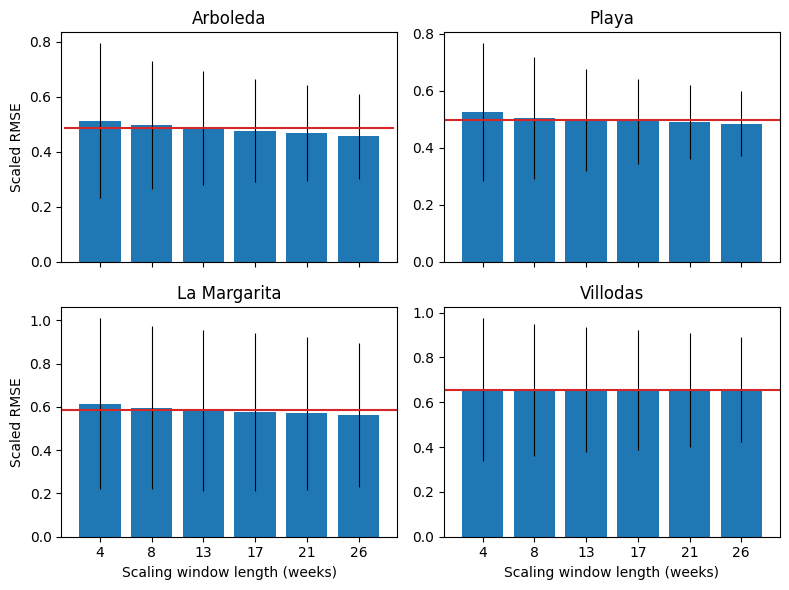

In [2]:
importlib.reload(forecast)

metrics = gen_utils.load_csv(metric_fil)
metrics = metrics[metrics.Trap_smoothing_flag==True]
metrics = metrics[metrics.Weather.str.contains('site')]
metrics = metrics[~metrics.Site.str.contains('baseline')]
metrics = metrics[metrics.Forecast_win==52]

sites = ['Arboleda', 'Playa', 'La_Margarita', 'Villodas']
#Avg. mosquitoes
avg_mosquitos = [8.718, 12.786, 1.488, 1.624]

fig, axs = plt.subplots(2,2, sharex=True, figsize=(8,6))
axs = axs.ravel()
    
fig_idx=0
for site,avg_mos,ax in zip(sites,avg_mosquitos,axs):
    site_metrics = metrics.copy(deep=True)
    site_metrics = site_metrics[site_metrics.Site.str.contains(site)]
    
    ax.bar(site_metrics.Scaler_win.astype('str'), site_metrics.RMSE_mu/avg_mos)
    ax.errorbar(site_metrics.Scaler_win.astype('str'), site_metrics.RMSE_mu/avg_mos, ls='none', yerr = site_metrics.RMSE_sig/avg_mos, ecolor='k', elinewidth=0.8)
    ax.hlines(site_metrics[site_metrics.Scaler_win==13].RMSE_mu/avg_mos, ax.get_xlim()[0], ax.get_xlim()[1], color='tab:red')
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.set_title(site.replace('_', ' '))
    if (fig_idx % 2)==0:
        ax.set_ylabel('Scaled RMSE')
    if fig_idx>1:
        ax.set_xlabel('Scaling window length (weeks)')
    
    fig_idx+=1
ax.set_xlim([-0.75, 5.75])
fig.tight_layout()
fig.savefig('{}/site_smoothed_justify_scaling_win.png'.format(metric_figures_path), dpi=300, bbox_inches='tight')


## Baseline comparison

Baseline involves scaling a year's worth of predictions to the mean of the corresponding year's worth of trap data. Thus, instead of forecasting we're just assessing how well the prediction curve matches the observed trap. This facilitates comparisons with MoLS results in [1].

[1] Lega, Joceline, Heidi E. Brown, and Roberto Barrera. "Aedes aegypti (Diptera: Culicidae) abundance model improved with relative humidity and precipitation-driven egg hatching." Journal of medical entomology 54.5 (2017): 1375-1384.

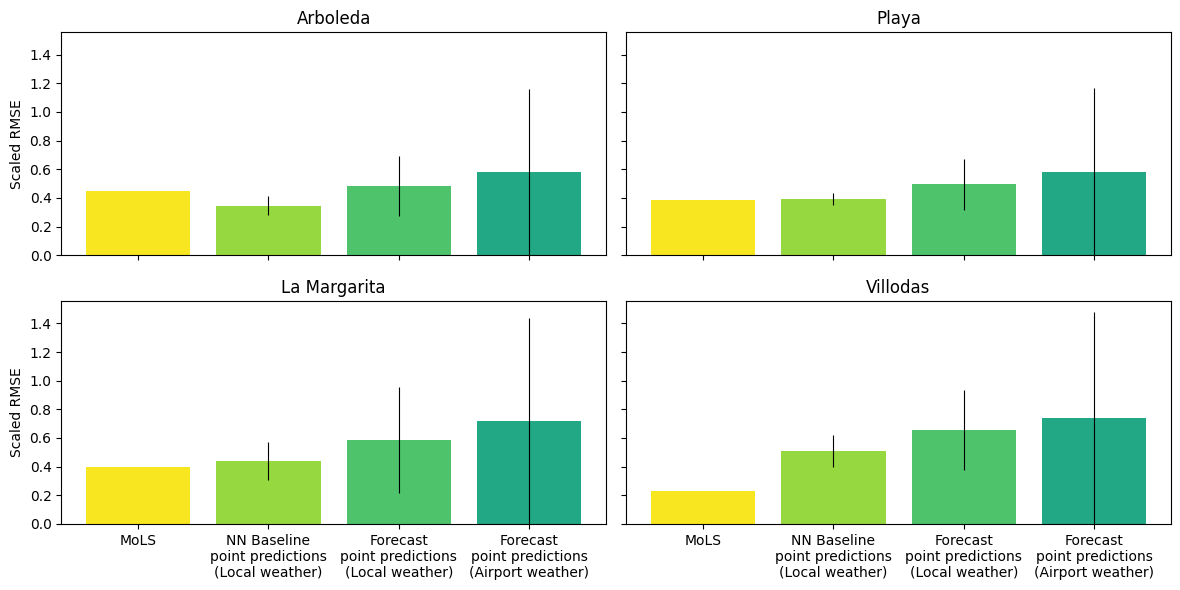

In [3]:
importlib.reload(forecast)

#From [1]. Order: Arboleda, Playa, La Margarita, Villodas
mols_vals = [3.92, 4.93, 0.588, 0.374]

#Avg. mosquitoes
avg_mosquitos = [8.718, 12.786, 1.488, 1.624]

metrics = gen_utils.load_csv(metric_fil)

#Baseline is scaling 1 year of neural network predictions to 1 year of trap data
baseline = metrics[metrics.Site.str.contains('baseline')]
baseline = baseline[baseline.Weather.str.contains('site')]
baseline = baseline[baseline.Trap_smoothing_flag == True]

#Forecasts (airport and site)
metrics = metrics[~metrics.Site.str.contains('baseline')]
metrics = metrics[metrics.Scaler_win==13]
metrics = metrics[metrics.Forecast_win==52]

#Airport weather
airport = metrics.copy(deep=True)
airport = airport[(airport.Weather.str.contains('airport')) & (airport.Trap_smoothing_flag==True)]

#Local weather
local = metrics.copy(deep=True)
local = local[(local.Weather.str.contains('site')) & (local.Trap_smoothing_flag==True)]

sites = ['Arboleda', 'Playa', 'La_Margarita', 'Villodas']

fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(12,6))
axs = axs.ravel()

cmap = plt.get_cmap('viridis')
colors = [cmap(0.99), cmap(0.84), cmap(0.72), cmap(0.6)]
    
fig_idx=0
labels = ['MoLS', 'NN Baseline\npoint predictions\n(Local weather)', 'Forecast\npoint predictions\n(Local weather)', 'Forecast\npoint predictions\n(Airport weather)']
for site,ax in zip(sites,axs):
    mols = mols_vals[fig_idx]
    avg_mos = avg_mosquitos[fig_idx]
    
    site_baseline = baseline[baseline.Site.str.contains(site)][['RMSE_mu', 'RMSE_sig']]
    local_forecast = local[local.Site.str.contains(site)][['RMSE_mu', 'RMSE_sig']]
    airport_forecast = airport[airport.Site.str.contains(site)][['RMSE_mu', 'RMSE_sig']]

    
    mus = np.asarray([mols, site_baseline.RMSE_mu.values[0], local_forecast.RMSE_mu.values[0], airport_forecast.RMSE_mu.values[0]])
    sigs = np.asarray([0, site_baseline.RMSE_sig.values[0], local_forecast.RMSE_sig.values[0], airport_forecast.RMSE_mu.values[0]])
    
    ax.bar(labels, 1/avg_mos*mus, color=colors)
    ax.errorbar(labels, 1/avg_mos*mus, ls='none', yerr = 1/avg_mos*sigs, ecolor='k', elinewidth=0.8)
    
    ax.set_xticklabels(labels, rotation=0, ha="center")
    ax.set_title(site.replace('_', ' '))
    if (fig_idx % 2)==0:
        ax.set_ylabel('Scaled RMSE')
    fig_idx+=1
fig.tight_layout()
fig.savefig('{}/mols_baseline_forecast_comparions.png'.format(metric_figures_path), dpi=300, bbox_inches='tight')
